In [139]:
def update_image_id(images, dataset_coco):
    img2id = {img['file_name']: img['id'] for img in images}
    dataset_coco['images'] = [img for img in  dataset_coco['images'] if img['file_name'] in img2id]
    # assert len(images) == len(dataset_coco['images']),print(len(images),len(dataset_coco['images']))
    old_images = [image['file_name'] for image in dataset_coco['images']]
    for image in images:
        img_file_name = image['file_name']
        assert image['file_name'] in old_images, f'{img_file_name}'
    id2id = {img['id']:img2id[img['file_name']] for img in dataset_coco['images']}
    dataset_coco['annotations']= [annotation for annotation in  dataset_coco['annotations'] if annotation['image_id'] in id2id.keys()]

    for image in dataset_coco['images']:
        image['id']= id2id[image['id']]
    
        
    for annotation in dataset_coco['annotations']:
        annotation['image_id'] = id2id[annotation['image_id']]
    
    return dataset_coco

In [140]:
import json

gt_path = '/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/groundtruth_coco.json'
pred_path = '/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/rule_based_coco.json'
# Load the COCO validation annotations
filtered_gt_path = '/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/filtered_groundtruth_coco.json'
filtered_pred_path = '/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/filtered_rule_predictions.json'
# Load the COCO validation annotations
with open(gt_path) as f:
    val_data = json.load(f)

# Load the COCO format predictions
with open(pred_path) as f:
    pred_data = json.load(f)
# pred_data=update_image_id(val_data['images'], pred_data)
with open('/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/scanned_pages.json') as f:
    scanned_pages = json.load(f)
# confidence_threshold = 0.5
# pred_data['annotations'] = [annot for annot in pred_data['annotations'] if annot['score'] >=confidence_threshold]

scanned_pages_id = [image['id'] for image in val_data['images'] if image['file_name'] in scanned_pages]
val_data['annotations']= [annot for annot in val_data['annotations'] if annot['image_id'] not in scanned_pages_id]
val_data['images'] =[img for img in val_data['images'] if img['id'] not in scanned_pages_id]

pred_data['annotations']= [annot for annot in pred_data['annotations'] if annot['image_id'] not in scanned_pages_id]
pred_data['images'] =[img for img in pred_data['images'] if img['id'] not in scanned_pages_id]
with open(filtered_gt_path, 'w') as f:
    json.dump(val_data,f,ensure_ascii=False,indent=4)
with open(filtered_pred_path, 'w') as f:
    json.dump(pred_data,f,ensure_ascii=False,indent=4)



In [141]:
scanned_pages_id = [image['id'] for image in val_data['images'] if image['file_name'] in scanned_pages]

In [142]:
from collections import defaultdict

# Map annotations to images
annotations = defaultdict(list)
for ann in val_data['annotations']:
    if ann['image_id'] not in scanned_pages_id:
        annotations[ann['image_id']].append(ann)

# Map predictions to images
predictions = defaultdict(list)
for pred in pred_data['annotations']:
    if pred['image_id'] not in scanned_pages_id:
        predictions[pred['image_id']].append(pred)


In [143]:
label_count ={}
for key in annotations.keys():
    for annot in annotations[key]:
        if annot['category_id'] in label_count:
            label_count[annot['category_id']]+=1
        else:
            label_count[annot['category_id']]=1 

In [144]:
label_count

{2: 2252, 1: 1400, 3: 1188, 0: 476, 6: 34, 4: 44}

In [145]:
def calculate_iou(box1, box2):
    """
    Calculate the Intersection over Union (IoU) of two bounding boxes.
    
    Parameters:
    box1, box2: Lists or tuples with coordinates [x1, y1, width, height]
    
    Returns:
    iou: IoU value
    """
    x1_1, y1_1, w1, h1 = box1
    x2_1, y2_1, w2, h2 = box2
    
    x1_2 = x1_1 + w1
    y1_2 = y1_1 + h1
    x2_2 = x2_1 + w2
    y2_2 = y2_1 + h2
    
    xi1 = max(x1_1, x2_1)
    yi1 = max(y1_1, y2_1)
    xi2 = min(x1_2, x2_2)
    yi2 = min(y1_2, y2_2)
    
    inter_area = max(0, xi2 - xi1) * max(0, yi2 - yi1)
    
    box1_area = w1 * h1
    box2_area = w2 * h2
    union_area = box1_area + box2_area - inter_area
    
    iou = inter_area / union_area if union_area > 0 else 0
    
    return iou


In [146]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score
import numpy as np

def is_significant_overlap(box1, box2, threshold=0.9):
    """
    Check if the IoU between two bounding boxes is greater than the given threshold.
    
    Parameters:
    box1, box2: Lists or tuples with coordinates [x1, y1, width, height]
    threshold: float, IoU threshold
    
    Returns:
    bool: True if IoU > threshold, else False
    """
    iou = calculate_iou(box1, box2)
    return iou > threshold

# Initialize confusion matrix components
y_true = []
y_pred = []

for image_id in annotations.keys():
    gt_labels = [ann['category_id'] for ann in annotations[image_id]]
    pred_labels = [pred['category_id'] for pred in predictions.get(image_id, [])]
    
    gt_matched = [False] * len(gt_labels)
    pred_matched = [False] * len(pred_labels)
    
    for i, gt in enumerate(annotations[image_id]):
        for j, pred in enumerate(predictions.get(image_id, [])):
            if is_significant_overlap(gt['bbox'], pred['bbox']):
                gt_matched[i] = True
                pred_matched[j] = True
                y_true.append(gt['category_id'])
                y_pred.append(pred['category_id'])
    
    for i, matched in enumerate(gt_matched):
        if not matched:
            y_true.append(annotations[image_id][i]['category_id'])
            y_pred.append('background')
    
    for j, matched in enumerate(pred_matched):
        if not matched:
            y_true.append('background')
            y_pred.append(predictions[image_id][j]['category_id'])


In [147]:
# Confidence threshold
confidence_threshold = 0.5

# Initialize confusion matrix components
y_true = []
y_pred = []

for image_id in annotations.keys():
    gt_labels = [ann['category_id'] for ann in annotations[image_id]]
    gt_boxes = [ann['bbox'] for ann in annotations[image_id]]
    
    pred_labels = [pred['category_id'] for pred in predictions.get(image_id, [])]
    pred_boxes = [pred['bbox'] for pred in predictions.get(image_id, [])]
    
    gt_matched = [False] * len(gt_labels)
    pred_matched = [False] * len(pred_labels)
    
    for i, gt_box in enumerate(gt_boxes):
        for j, pred_box in enumerate(pred_boxes):
            if is_significant_overlap(gt_box, pred_box):
                gt_matched[i] = True
                pred_matched[j] = True
                y_true.append(gt_labels[i])
                y_pred.append(pred_labels[j])
    
    for i, matched in enumerate(gt_matched):
        if not matched:
            y_true.append(gt_labels[i])
            y_pred.append('background')
    
    for j, matched in enumerate(pred_matched):
        if not matched:
            y_true.append('background')
            y_pred.append(pred_labels[j])

# Convert category IDs to category names if necessary
category_id_to_name = {cat['id']: cat['name'] for cat in val_data['categories']}
category_id_to_name['background'] = 'background'

y_true = [category_id_to_name.get(label, 'background') for label in y_true]
y_pred = [category_id_to_name.get(label, 'background') for label in y_pred]

labels = list(category_id_to_name.values())

conf_mat = confusion_matrix(y_true, y_pred, labels=labels)


In [148]:
conf_mat_normalized = conf_mat#.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]


In [149]:
precision = precision_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
recall = recall_score(y_true, y_pred, labels=labels, average=None, zero_division=0)
print('Precision@0.9')
for label, score in zip(labels,precision):
    print(f'\t{label}:{score:.4f}')
print('Recall@0.9')
for label, score in zip(labels,recall):
    print(f'\t{label}:{score:.4f}')

Precision@0.9
	text:0.0000
	title:0.0000
	list-item:0.0000
	table:0.0000
	figure:0.0000
	form:0.0000
	footnote:0.0000
	useless:0.0000
	background:0.0000
Recall@0.9
	text:0.0000
	title:0.0000
	list-item:0.0000
	table:0.0000
	figure:0.0000
	form:0.0000
	footnote:0.0000
	useless:0.0000
	background:0.0000


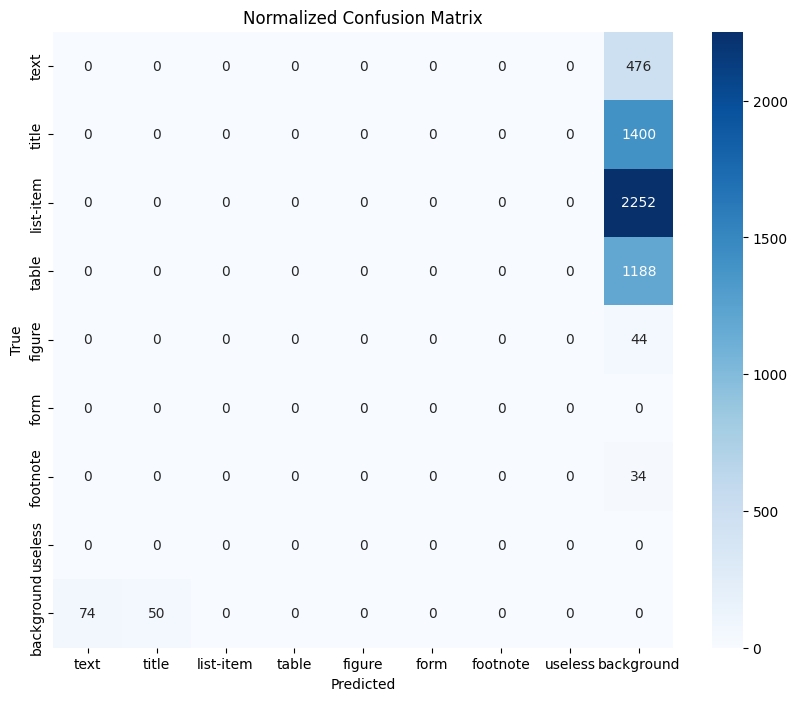

In [150]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat_normalized, annot=True, fmt='.0f', xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Normalized Confusion Matrix')
plt.show()


In [151]:
conf_mat.sum(axis=1)

array([ 476, 1400, 2252, 1188,   44,    0,   34,    0,  124])

In [152]:
conf_mat.sum(axis=0)

array([  74,   50,    0,    0,    0,    0,    0,    0, 5394])

In [153]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load the ground truth annotations
coco_gt = COCO(filtered_gt_path)
with open(filtered_pred_path, 'r') as f:
    predictions_data = json.load(f)

# Convert predictions to the required format
predictions = []
for ann in predictions_data['annotations']:
    prediction = {
        'image_id': ann['image_id'],
        'category_id': ann['category_id'],
        'bbox': ann['bbox'],
        'score': ann['score'] if 'score' in ann else 1.0  # Use a default score if not provided
    }
    predictions.append(prediction)

# Save the converted predictions to a new JSON file
converted_predictions_path = f'/home/vinhvq11/Desktop/PDF_extraction/data_process/benchmarks/tpbank_benchmark/rule_predictions.json'
with open(converted_predictions_path, 'w') as f:
    json.dump(predictions, f)

# Load the converted predictions
coco_dt = coco_gt.loadRes(converted_predictions_path)
# Load the predicted annotations

# Initialize the COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')  # 'bbox', 'segm', 'keypoints'

# Run the evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

overall_metrics = {
    "AP": coco_eval.stats[0],
    "AP50": coco_eval.stats[1],
    "AP75": coco_eval.stats[2],
    "APs": coco_eval.stats[3],
    "APm": coco_eval.stats[4],
    "APl": coco_eval.stats[5],
}

# Class-wise evaluation
categories = coco_gt.loadCats(coco_gt.getCatIds())
category_names = [cat['name'] for cat in categories]
category_ids = [cat['id'] for cat in categories]

class_wise_metrics = {}
for cat_id, cat_name in zip(category_ids, category_names):
    coco_eval.params.catIds = [cat_id]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_wise_metrics[f"AP-{cat_name}"] = coco_eval.stats[0]

# Combine overall and class-wise metrics
eval_results = {
    "bbox": {**overall_metrics, **class_wise_metrics}
}

# Save evaluation results to a JSON file
eval_results_path = 'eval_rule/evaluation_results.json'
with open(eval_results_path, 'w') as f:
    json.dump(eval_results, f, indent=4)

print(f"Evaluation results saved to {eval_results_path}")

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.16s).
Accumulating evaluation results...
DONE (t=0.05s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets

# Evaluate by domain


In [154]:
import json
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

# Load the ground truth annotations
# ground_truth_path = 'path_to_groundtruth.json'
coco_gt = COCO(filtered_gt_path)

# Load the predictions (which are in COCO dataset format)
# predictions_path = 'path_to_predictions.json'
with open(filtered_pred_path, 'r') as f:
    predictions_data = json.load(f)

# Define the mapping of specific categories to a general class
general_class_name = "text_block"
specific_categories = ["text", "title", "list-item"]
category_mapping = {cat['id']: general_class_name for cat in coco_gt.loadCats(coco_gt.getCatIds()) if cat['name'] in specific_categories}

# Create a new category for the general class in the ground truth
new_categories = [cat for cat in coco_gt.dataset['categories'] if cat['name'] not in specific_categories]
general_class_id = max(cat['id'] for cat in new_categories) + 1
new_categories.append({"id": general_class_id, "name": general_class_name})

# Modify the category IDs in ground truth annotations
new_annotations = []
for ann in coco_gt.dataset['annotations']:
    if ann['category_id'] in category_mapping:
        ann['category_id'] = general_class_id
    new_annotations.append(ann)

# Create a new ground truth dataset with modified annotations
new_ground_truth = coco_gt.dataset.copy()
new_ground_truth['categories'] = new_categories
new_ground_truth['annotations'] = new_annotations

# Save the new ground truth dataset
modified_ground_truth_path = 'modified_groundtruth.json'
with open(modified_ground_truth_path, 'w') as f:
    json.dump(new_ground_truth, f)

# Load the new ground truth dataset
coco_gt = COCO(modified_ground_truth_path)

# Modify the category IDs in predictions
new_predictions = []
for ann in predictions_data['annotations']:
    if ann['category_id'] in category_mapping:
        ann['category_id'] = general_class_id
    prediction = {
        'image_id': ann['image_id'],
        'category_id': ann['category_id'],
        'bbox': ann['bbox'],
        'score': ann['score'] if 'score' in ann else 1.0  # Use a default score if not provided
    }
    new_predictions.append(prediction)

# Save the modified predictions
modified_predictions_path = 'modified_predictions.json'
with open(modified_predictions_path, 'w') as f:
    json.dump(new_predictions, f)

# Load the modified predictions
coco_dt = coco_gt.loadRes(modified_predictions_path)

# Initialize the COCOeval object
coco_eval = COCOeval(coco_gt, coco_dt, 'bbox')  # 'bbox', 'segm', 'keypoints'

# Run the overall evaluation
coco_eval.evaluate()
coco_eval.accumulate()
coco_eval.summarize()

# Extract overall metrics
overall_metrics = {
    "AP": coco_eval.stats[0],
    "AP50": coco_eval.stats[1],
    "AP75": coco_eval.stats[2],
    "APs": coco_eval.stats[3],
    "APm": coco_eval.stats[4],
    "APl": coco_eval.stats[5],
}

# Class-wise evaluation
categories = coco_gt.loadCats(coco_gt.getCatIds())
category_names = [cat['name'] for cat in categories]
category_ids = [cat['id'] for cat in categories]

class_wise_metrics = {}
for cat_id, cat_name in zip(category_ids, category_names):
    coco_eval.params.catIds = [cat_id]
    coco_eval.evaluate()
    coco_eval.accumulate()
    coco_eval.summarize()
    class_wise_metrics[f"AP-{cat_name}"] = coco_eval.stats[0]

# Combine overall and class-wise metrics
eval_results = {
    "bbox": {**overall_metrics, **class_wise_metrics}
}

# Save evaluation results to a JSON file
eval_results_path = 'evaluation_results.json'
with open(eval_results_path, 'w') as f:
    json.dump(eval_results, f, indent=4)

print(f"Evaluation results saved to {eval_results_path}")


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.18s).
Accumulating evaluation results...
DONE (t=0.04s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.000
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxD